In [1]:
%load_ext autoreload
%autoreload 2

# Detection task

"Detection task" refers to the ability of the classifier to identify a sequence as either an erroneously-truncated selenoprotein, or a full-length non-selenoprotein. For this task, we used full-length negative normal proteins as negative test cases. The negative cases did *not* include full-length selenoproteins; we are basing this project on the observation that selenoproteins are misidentified, so full-length selenoproteins will not be present in the data we use to validate the model. The positive cases consisted of selenoproteins truncated at the *first* selenocysteine residue only. 

In [2]:
# Define the data and figure directories. 
DATA_DIR = '/home/prichter/Documents/selenobot/data/uniprot_2023_03/detect' 
FIGURE_DIR = '/home/prichter/Documents/selenobot/figures/'

In [3]:
from src.classifiers import EmbeddingClassifier, AacClassifier
from src.datasets import dataloader_from_csv
from utils.data import csv_ids, csv_labels

import os
import matplotlib.pyplot as plt
import seaborn as sns

/home/prichter/Documents/selenobot/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prichter/Documents/selenobot/env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/prichter/Documents/selenobot/env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently Fals

In [4]:
# Paths where the train and test data are stored. 
train_path = os.path.join(DATA_DIR, 'train.csv')
test_path = os.path.join(DATA_DIR, 'test.csv')

# Path where all amino acid sequences are stored. 
seq_path = os.path.join(DATA_DIR, 'all.fasta')

## Testing the benchmark

In [35]:
# First load the data into a dataset object. 
train_dataloader = dataloader_from_csv(seq_path, batch_size=6, type_='seq', ids=csv_ids(train_path), labels=csv_labels(train_path))
test_dataloader = dataloader_from_csv(seq_path, batch_size=16, type_='seq', ids=csv_ids(test_path), labels=csv_labels(test_path))

# train_dataloader = dataloader_from_csv(train_path, batch_size=16, type_='emb')
# test_dataloader = dataloader_from_csv(test_path, batch_size=16, type_='emb')

In [36]:
# First, try training with no other weight, to get a sense of how many epochs to use.
model = AacClassifier()
# model = EmbeddingClassifier(1024)

I am curious about how the weight passed into the `WeightedBCELoss` will affect the performance on batches with selenoprotein relative to batches without selenoprotein. For now, I will test out different values on the `AacClassifier`, mostly to see if there *are* any loss function weights which might allow the model to decrease training loss on batches with and without selenoproteins simultaneously (or if this method of binary classification simply isn't sufficient). Based on some preliminary runs, it seems as though around 20 epochs is enough time for the `AacClassifier` to get about as good as it will get, so I will stick with this number for now. 

In [37]:
aac_infos = []
for bce_loss_weight in [1, 10, 100, 1000, 10000, 100000]:
    model.reset() # Reset the model weights. 
    aac_info = model._train(train_dataloader, val=test_dataloader, epochs=15, lr=0.001, bce_loss_weight=bce_loss_weight)
    aac_infos.append(info)

classifiers.Classifier._train: 100%|██████████| 15/15 [02:07<00:00,  8.50s/it, val_acc=0]


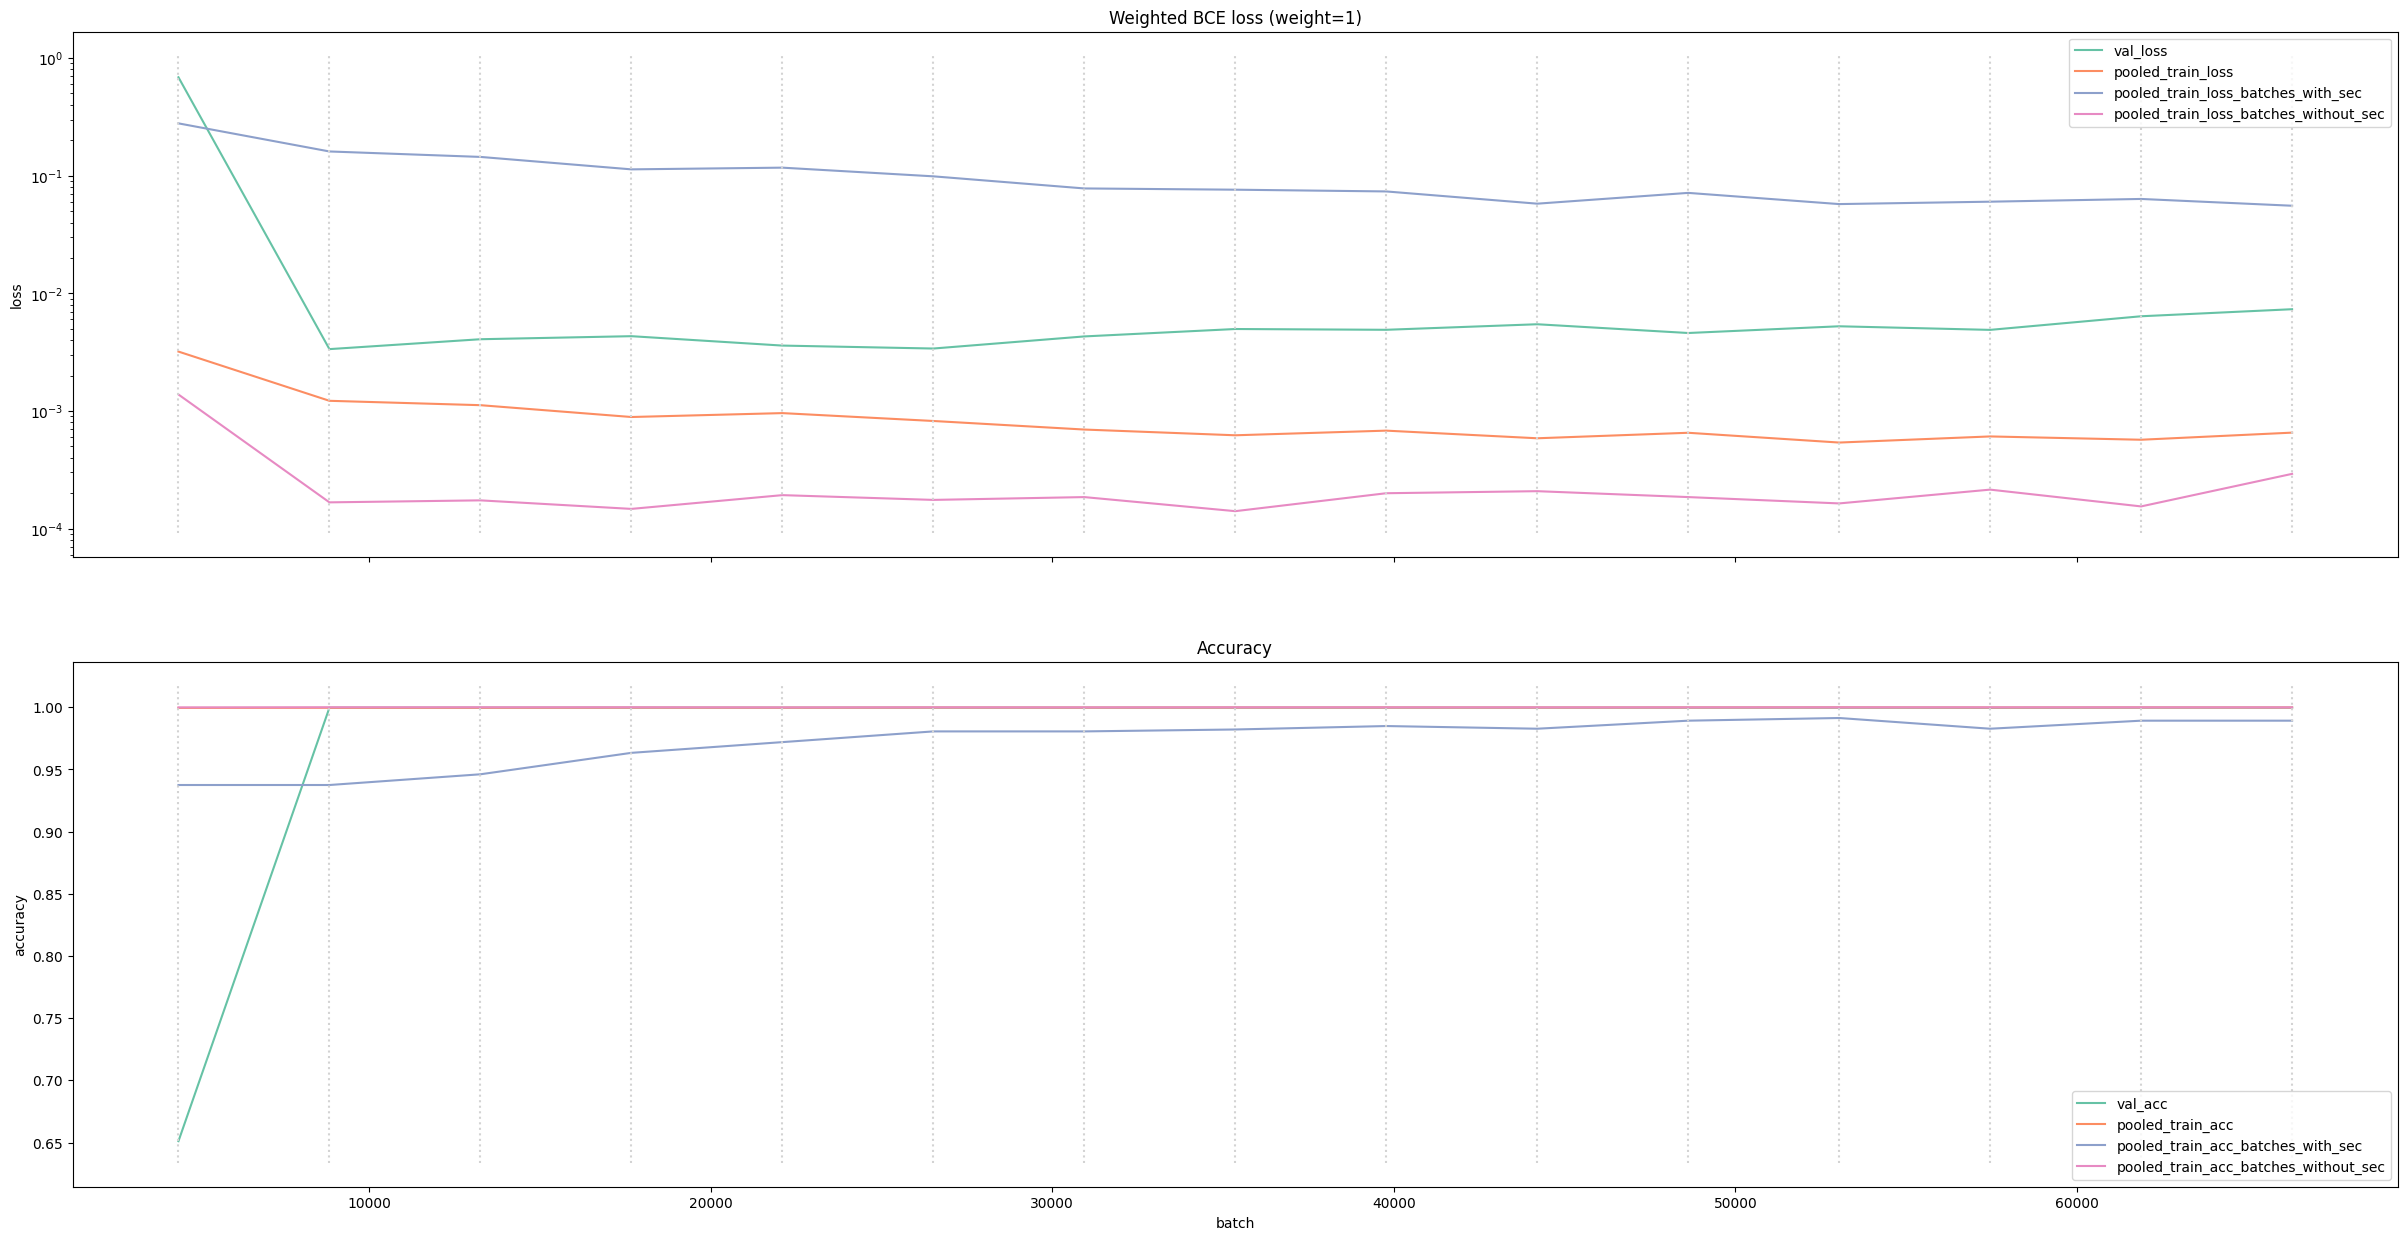

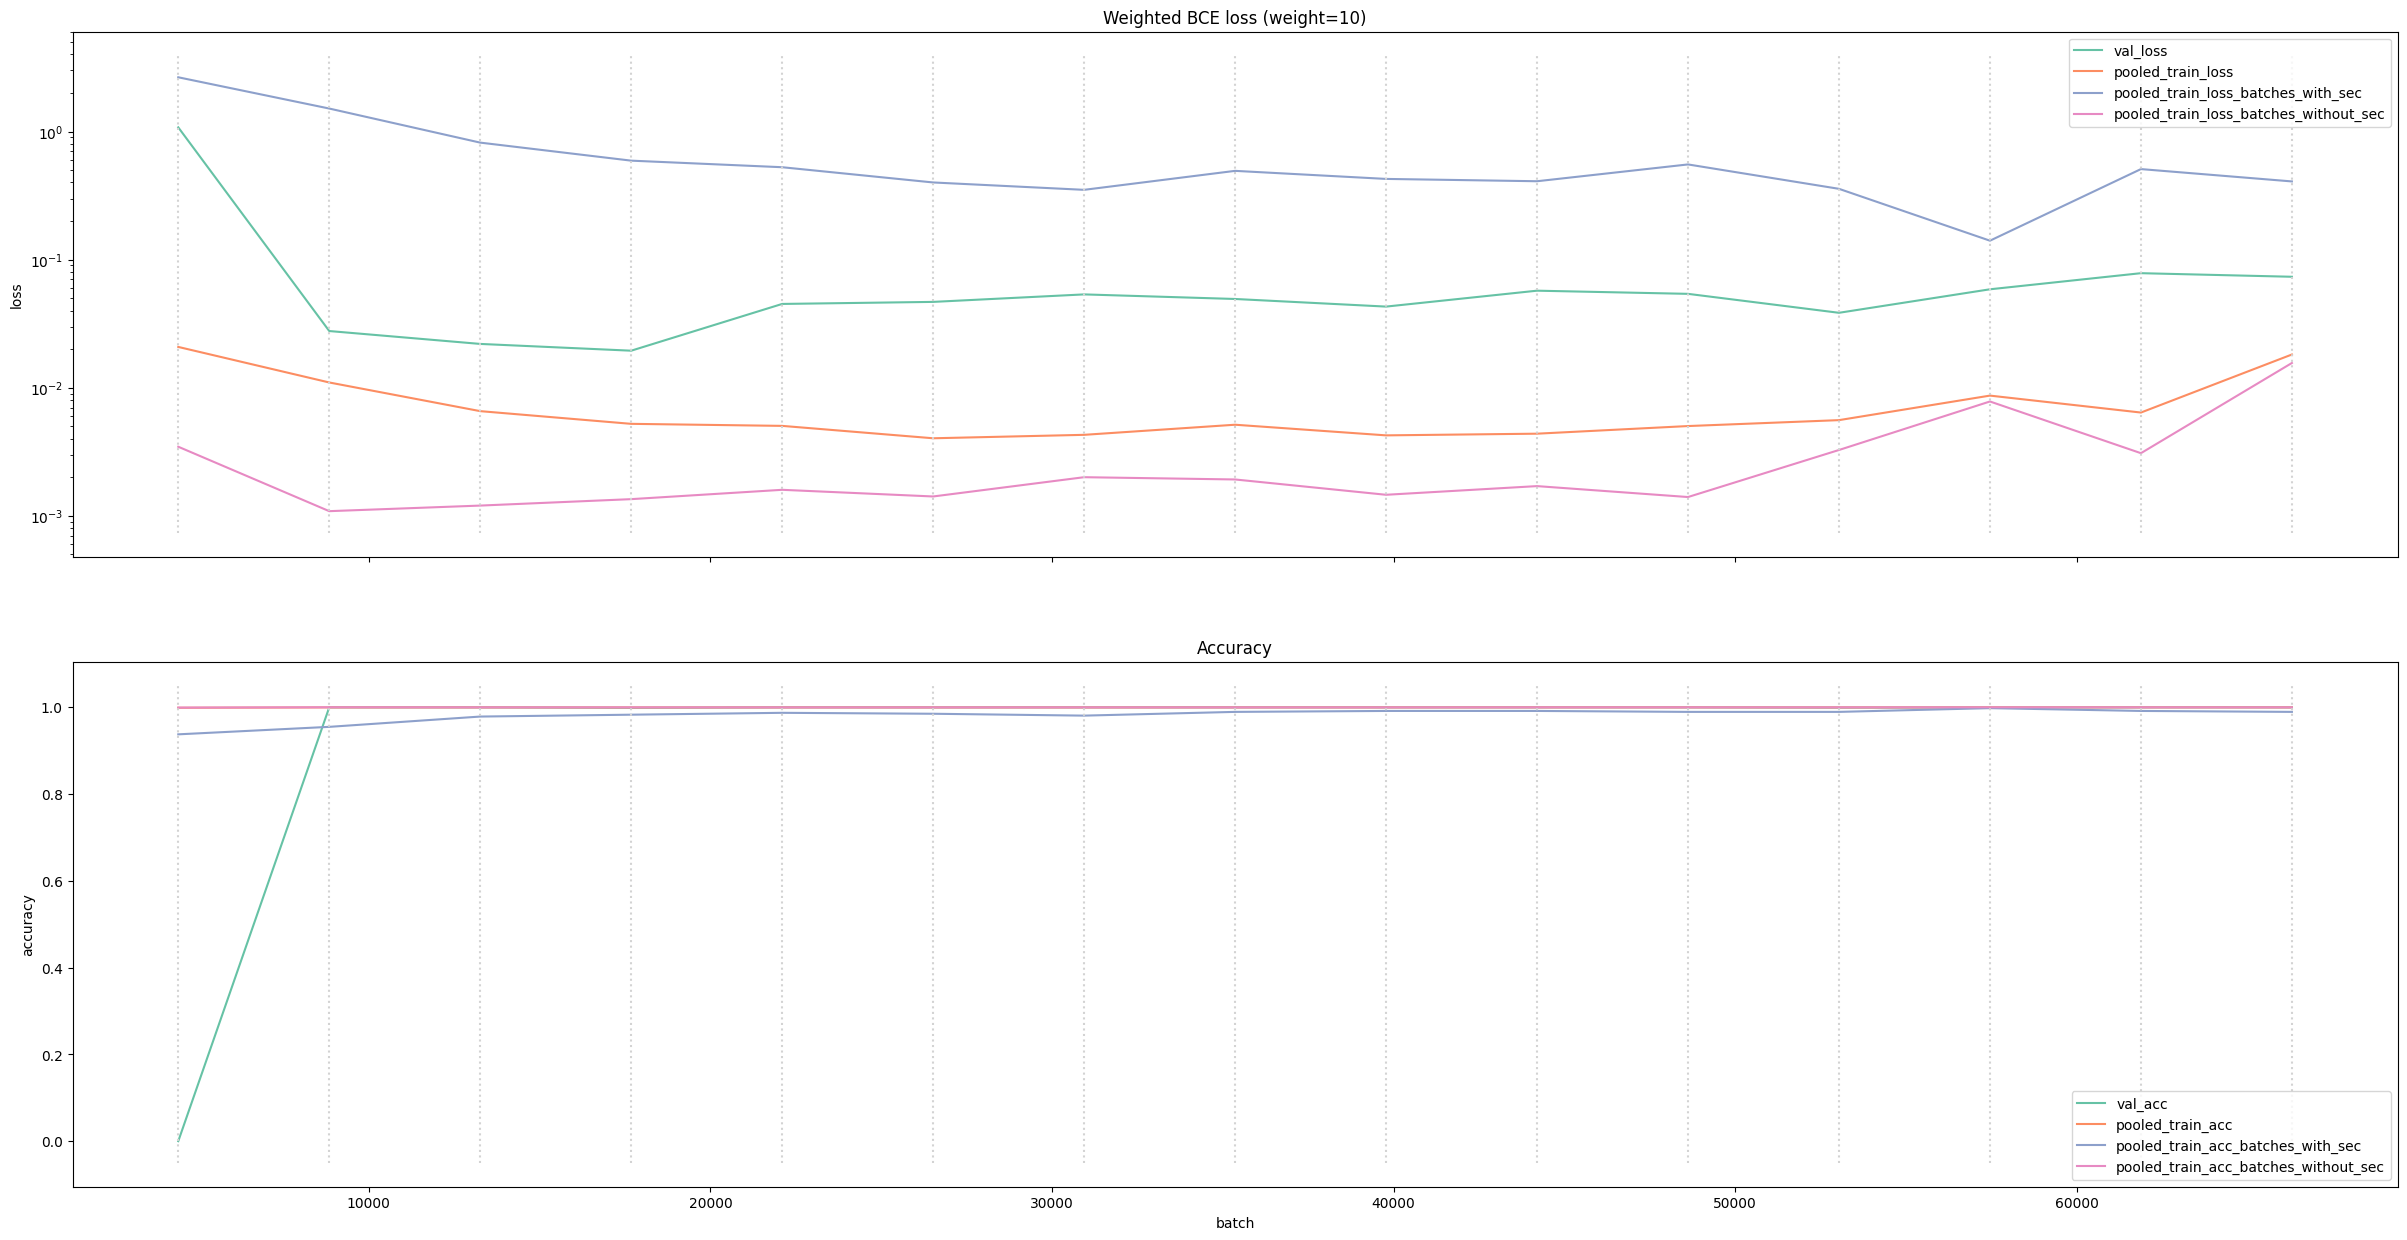

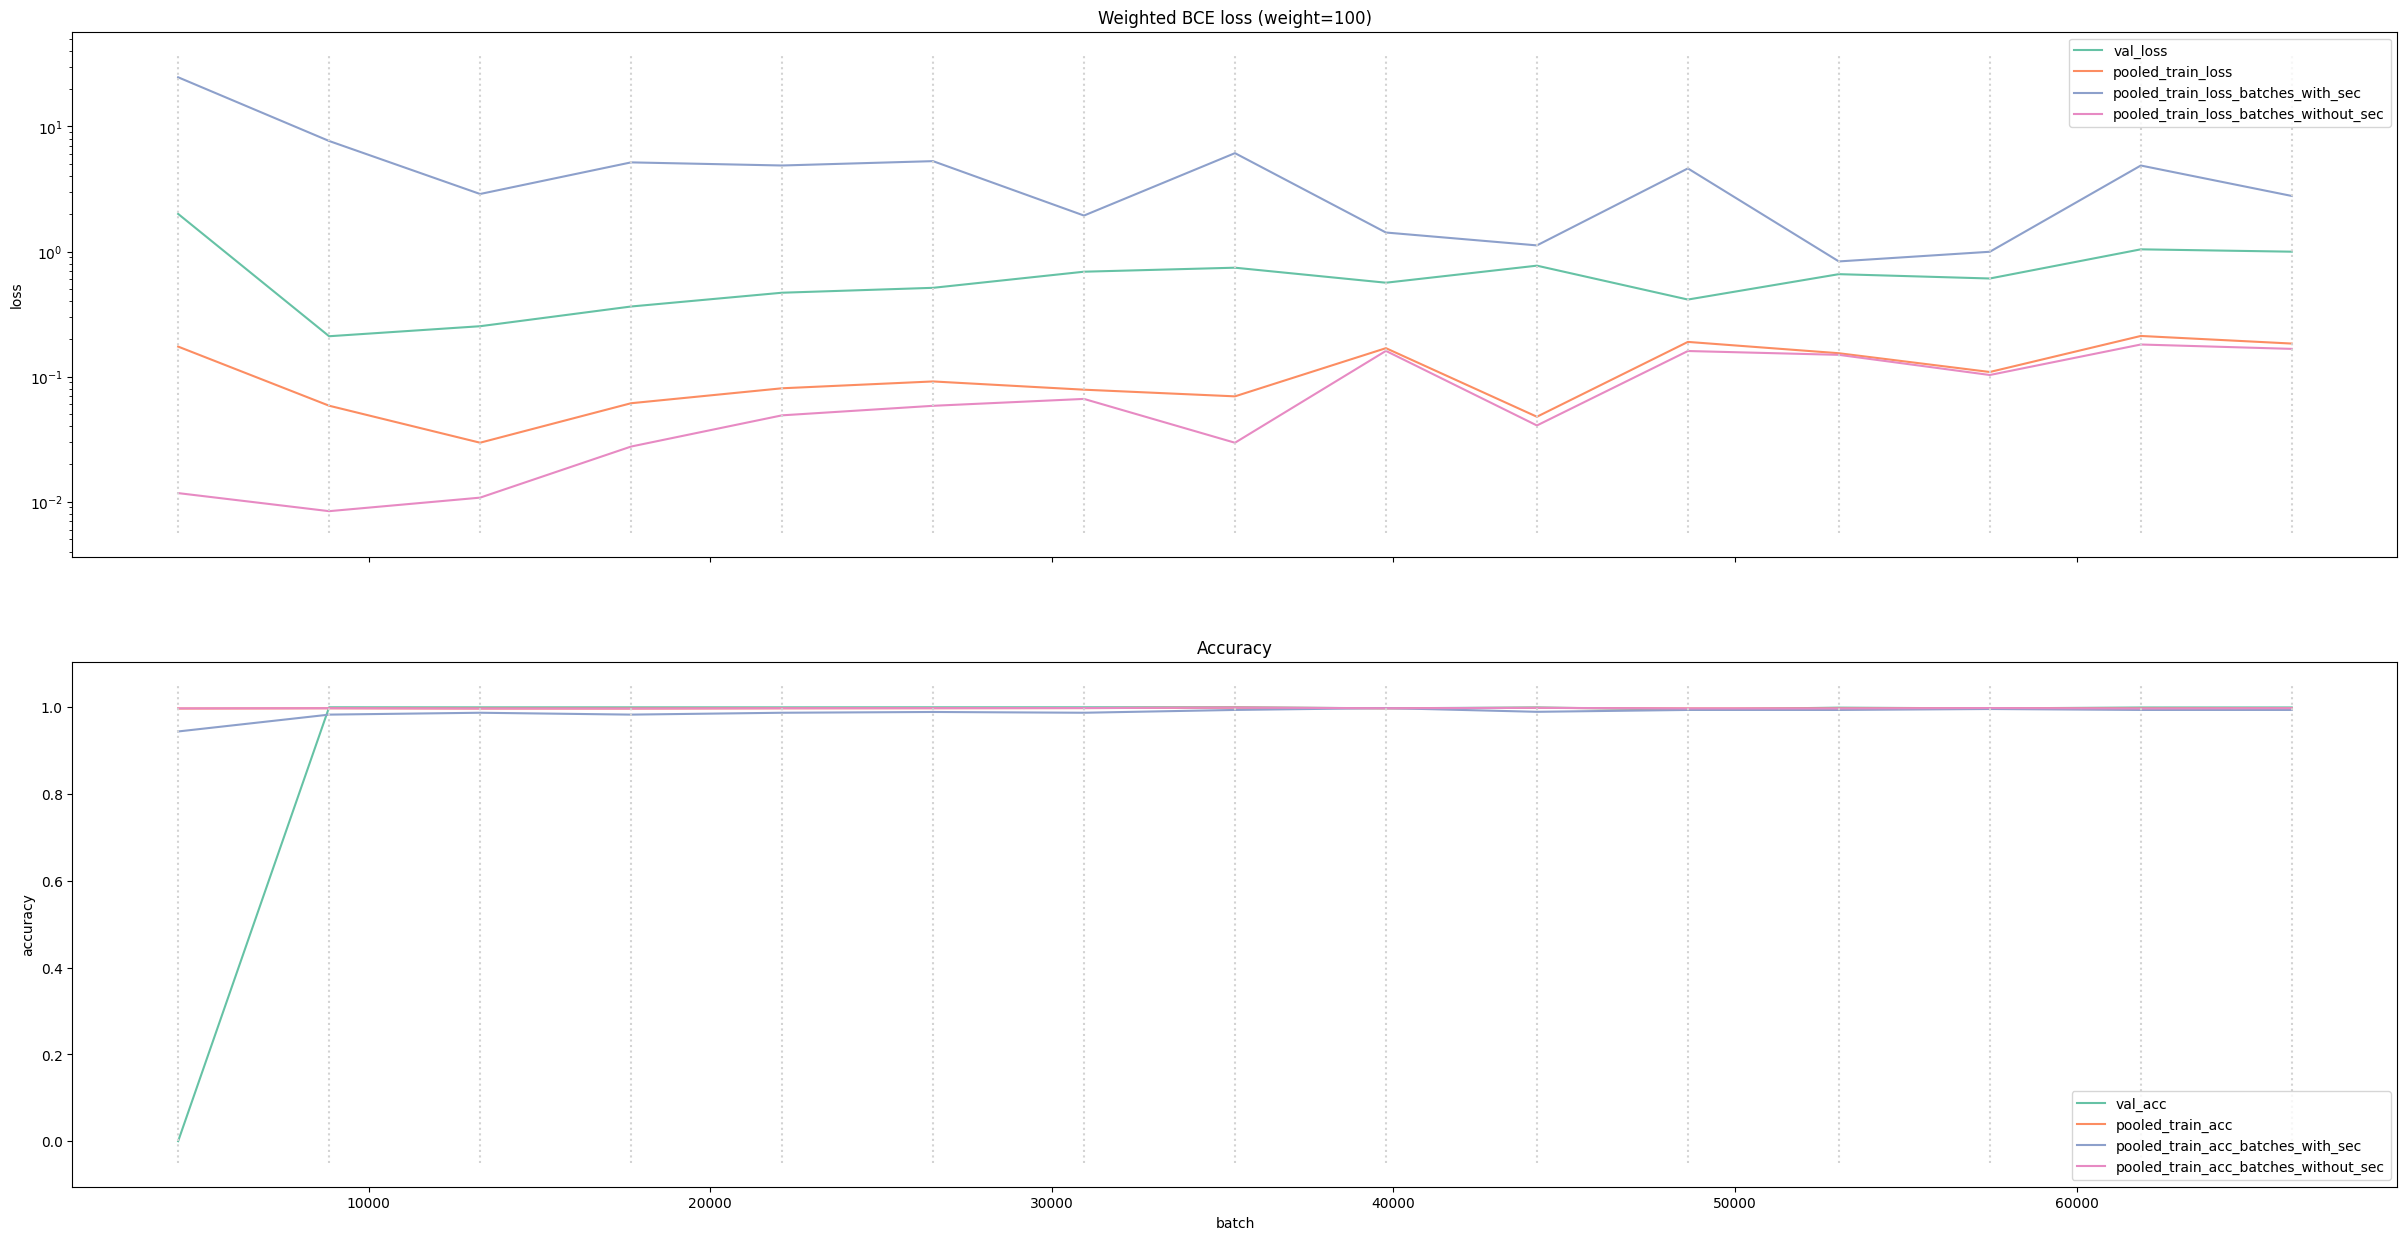

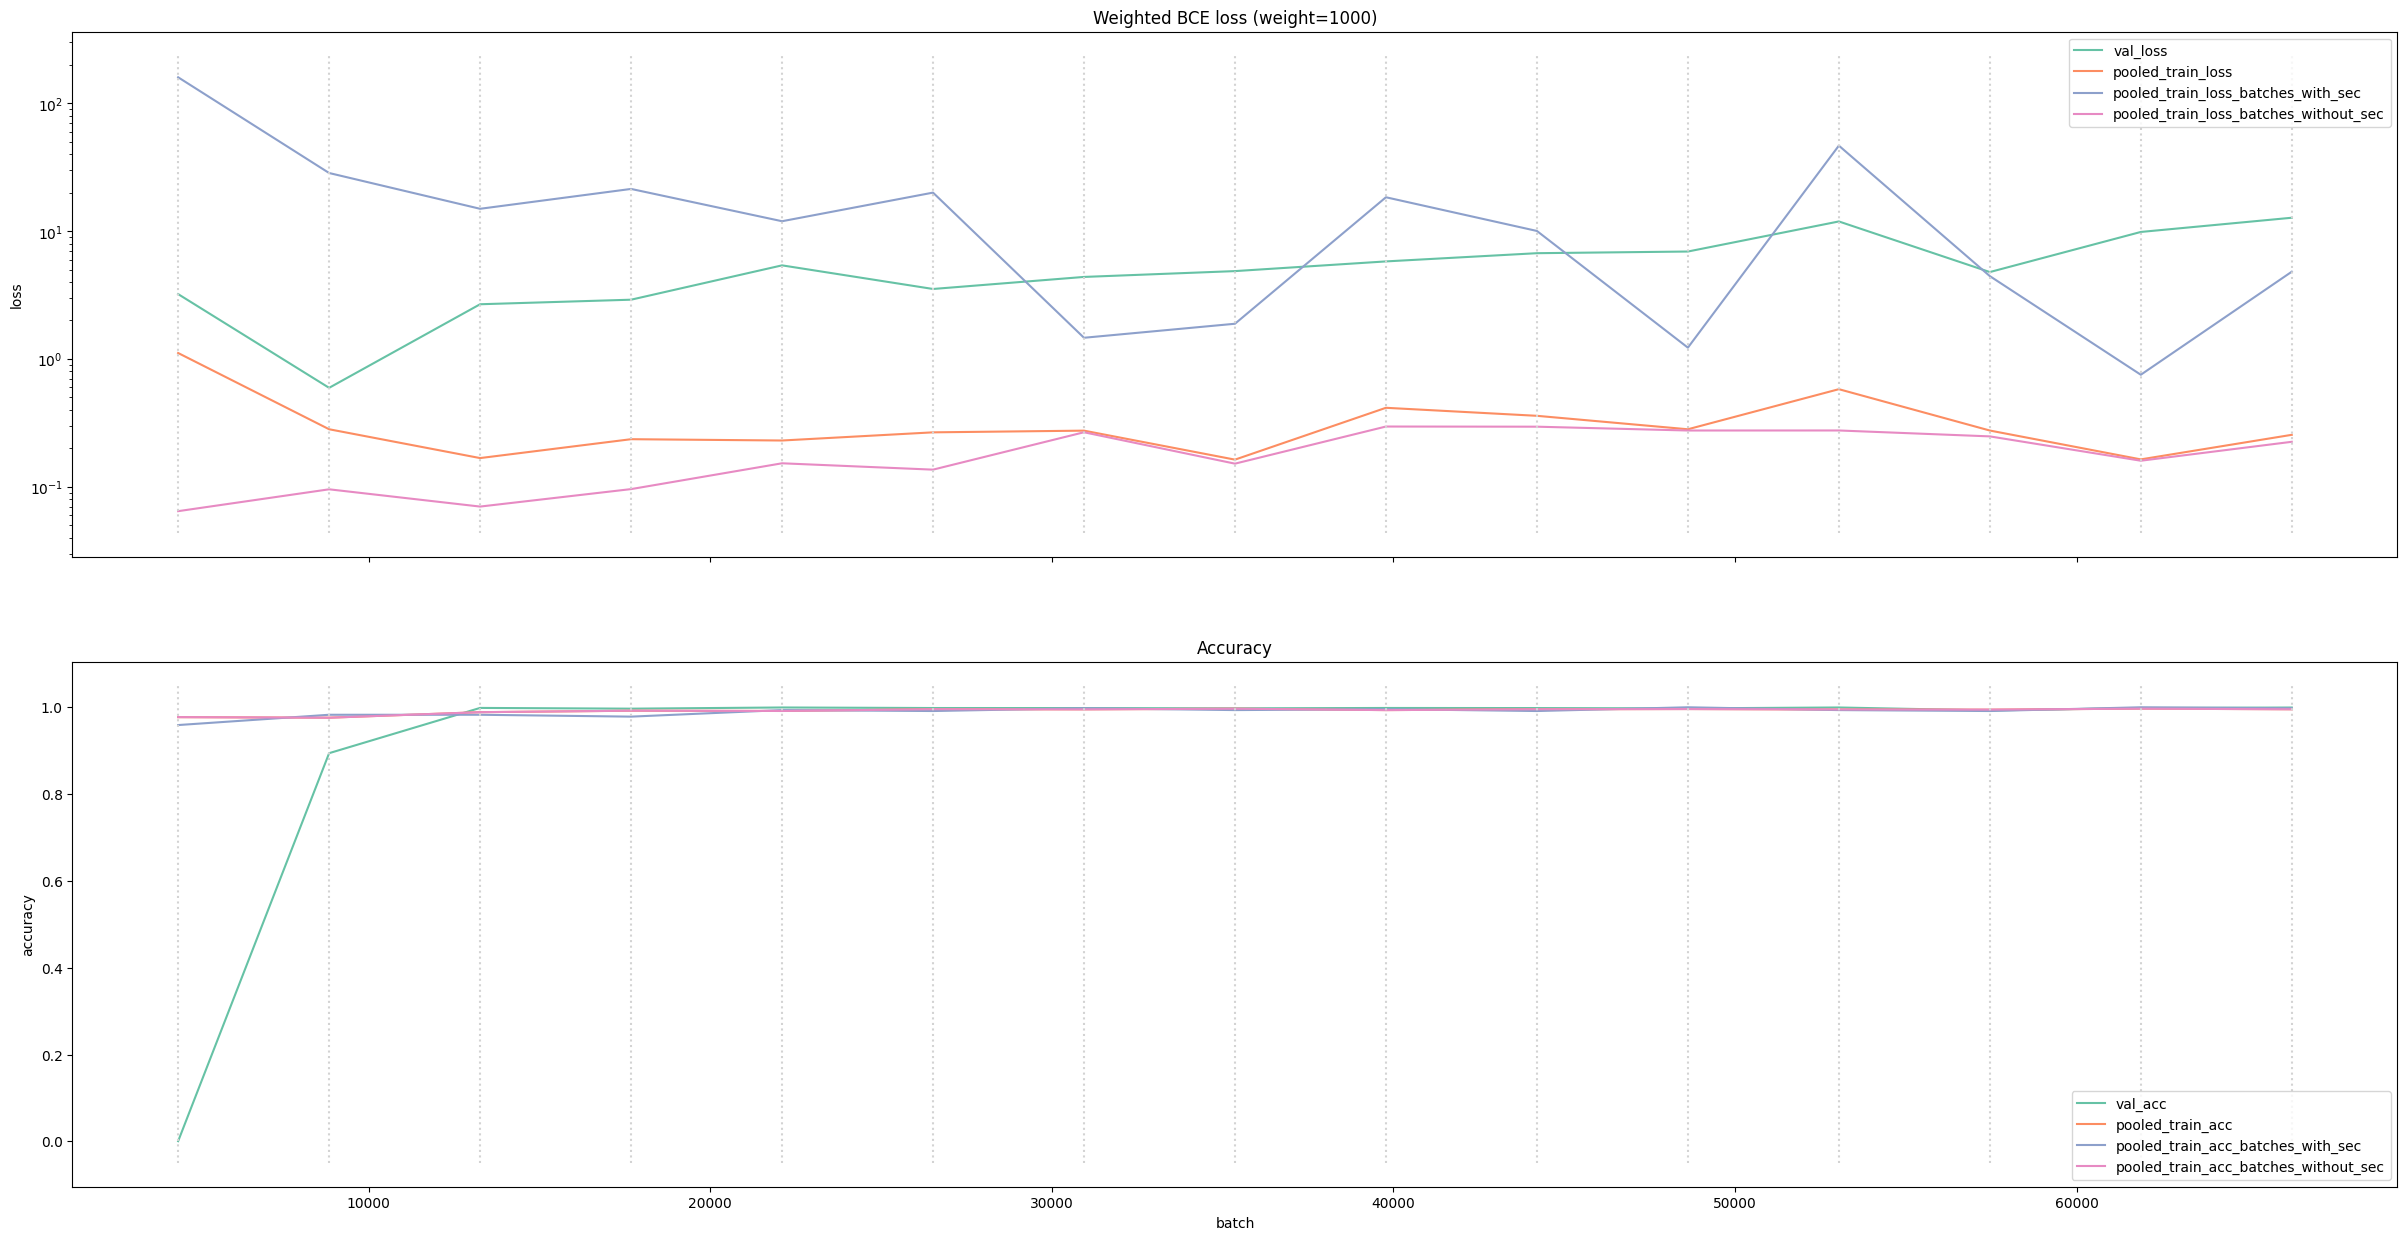

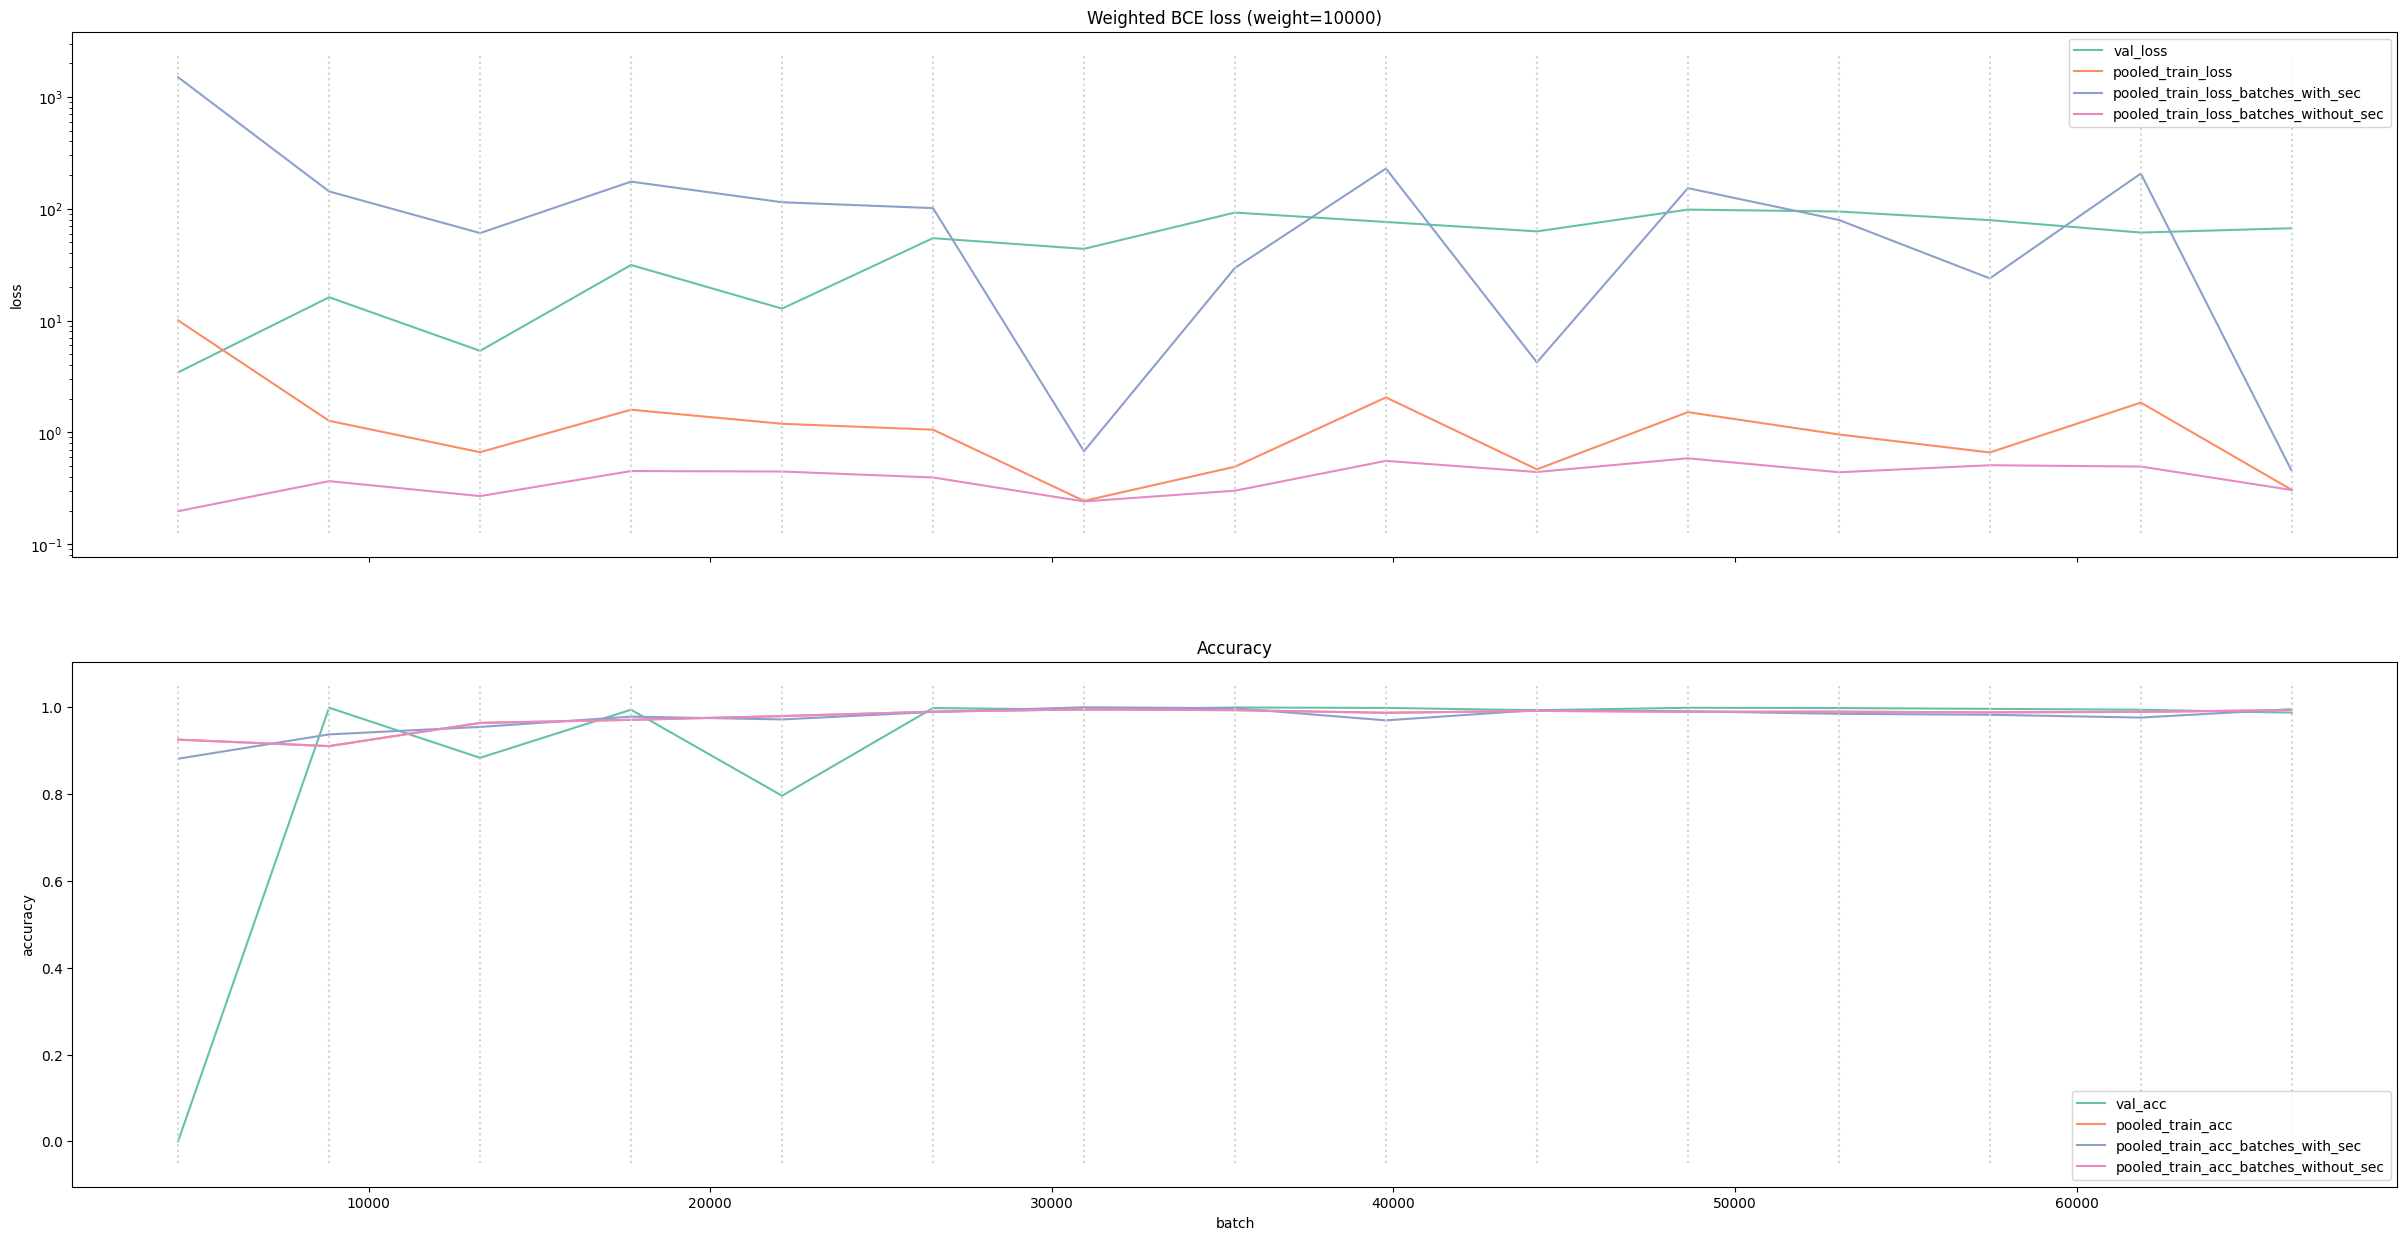

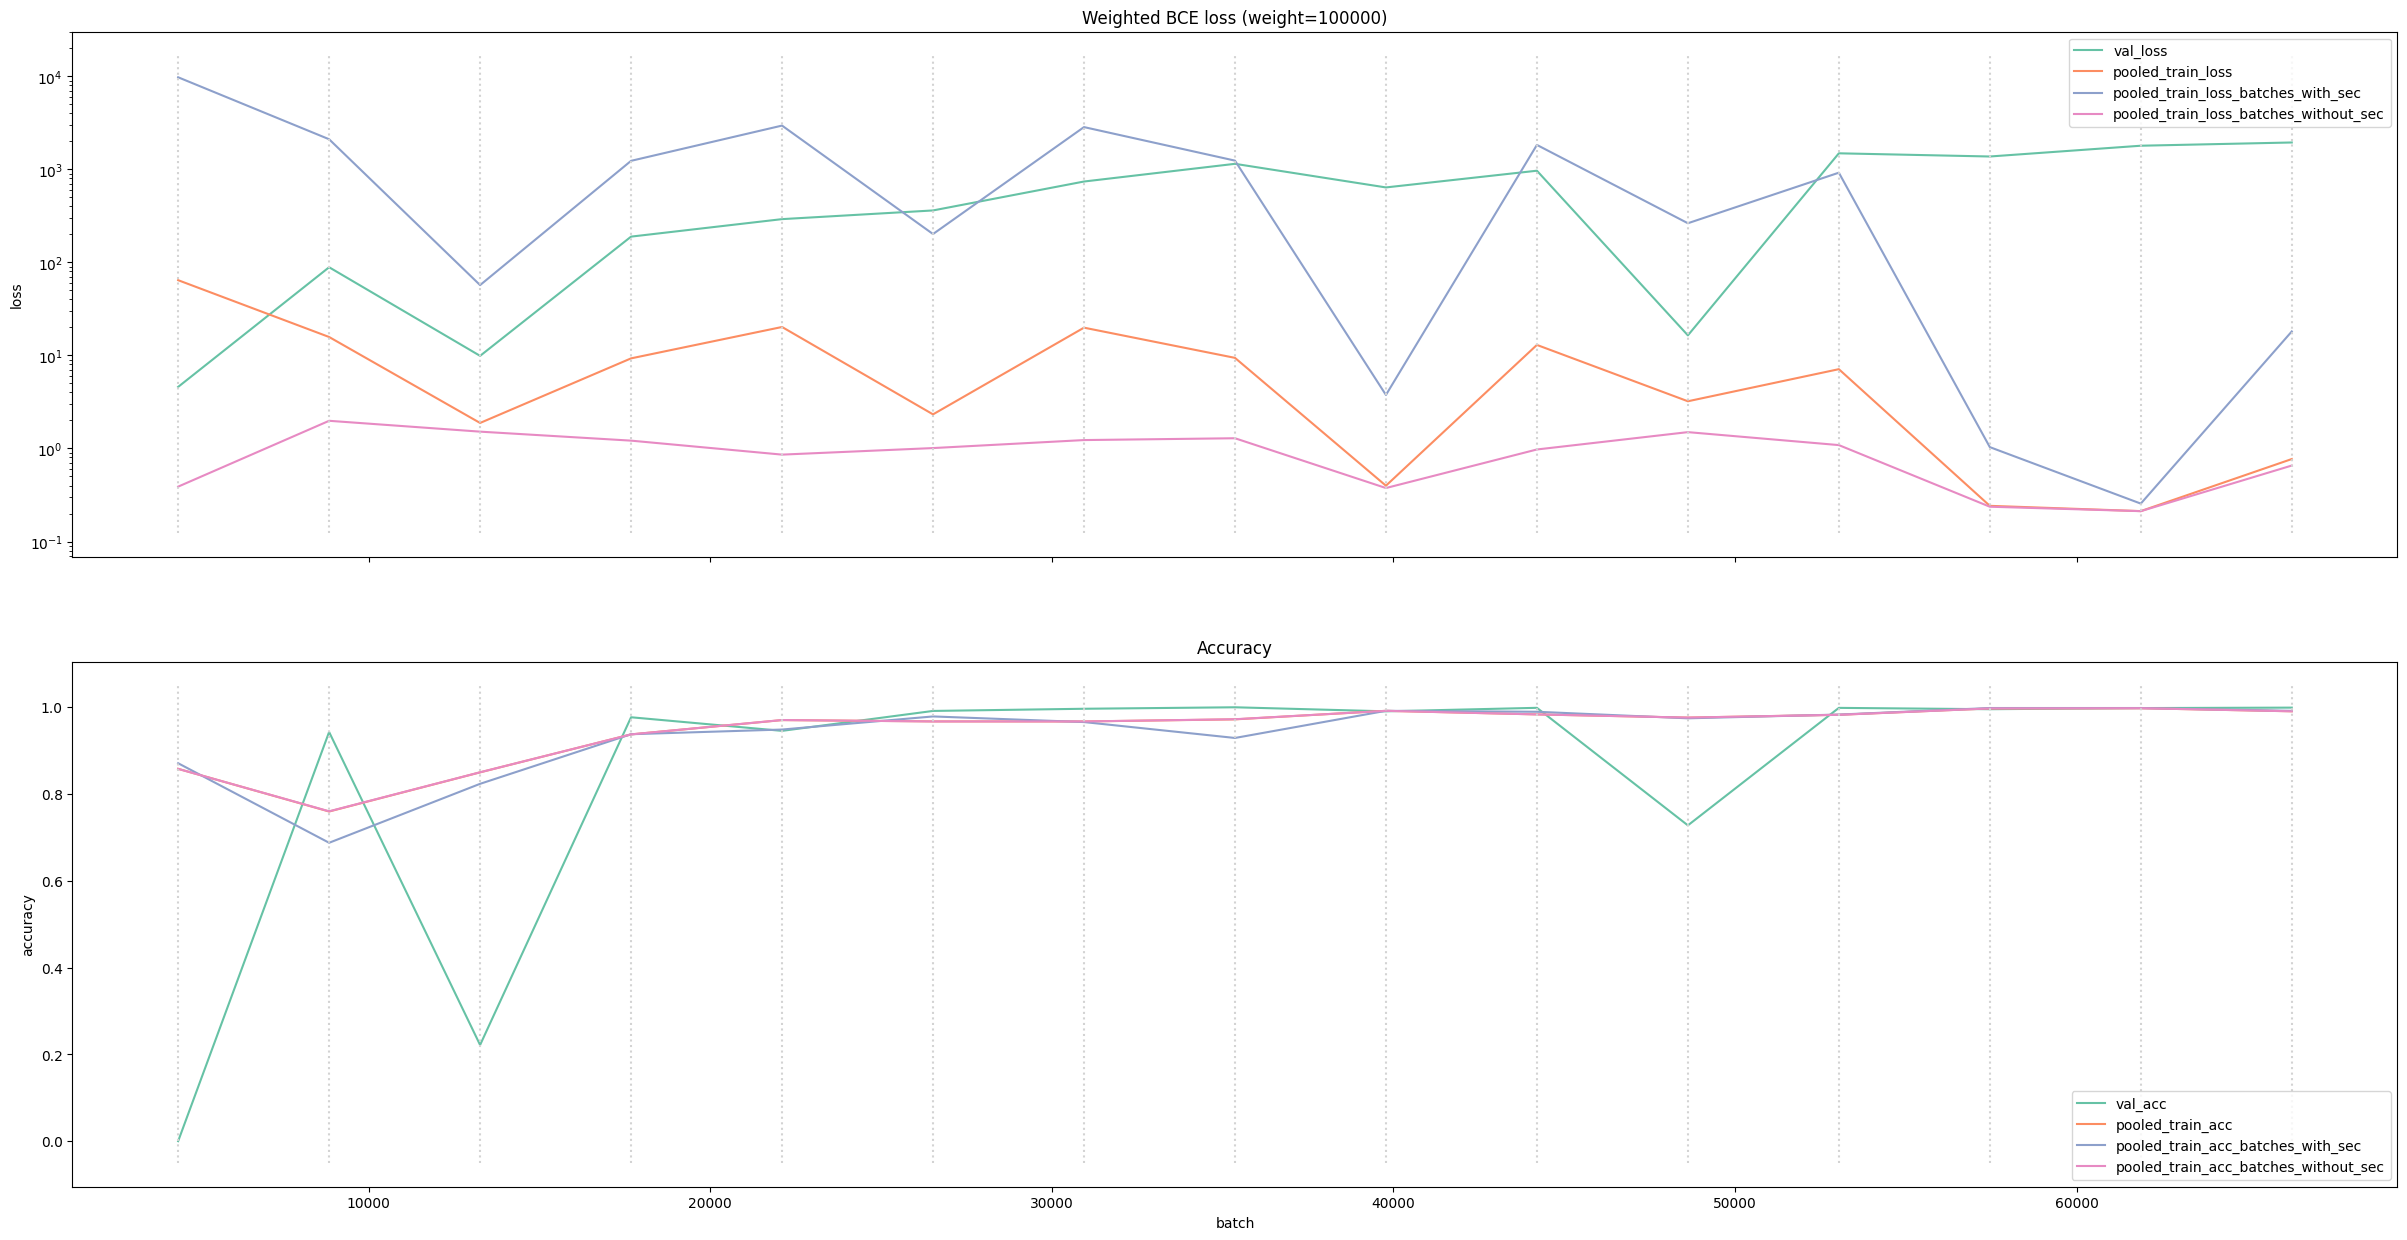

In [47]:
from utils.plot import *
# plot_train_losses(infos[2:3], path='emb_train_losses.png', title='EmbeddingClassifier training loss with varying BCE loss weights')
for info, weight in zip(infos, [1, 10, 100, 1000, 10000, 100000]):
    plot_train_(info, path=FIGURE_DIR + f'aac_train_weight={weight}_pooled.png', pool=True)

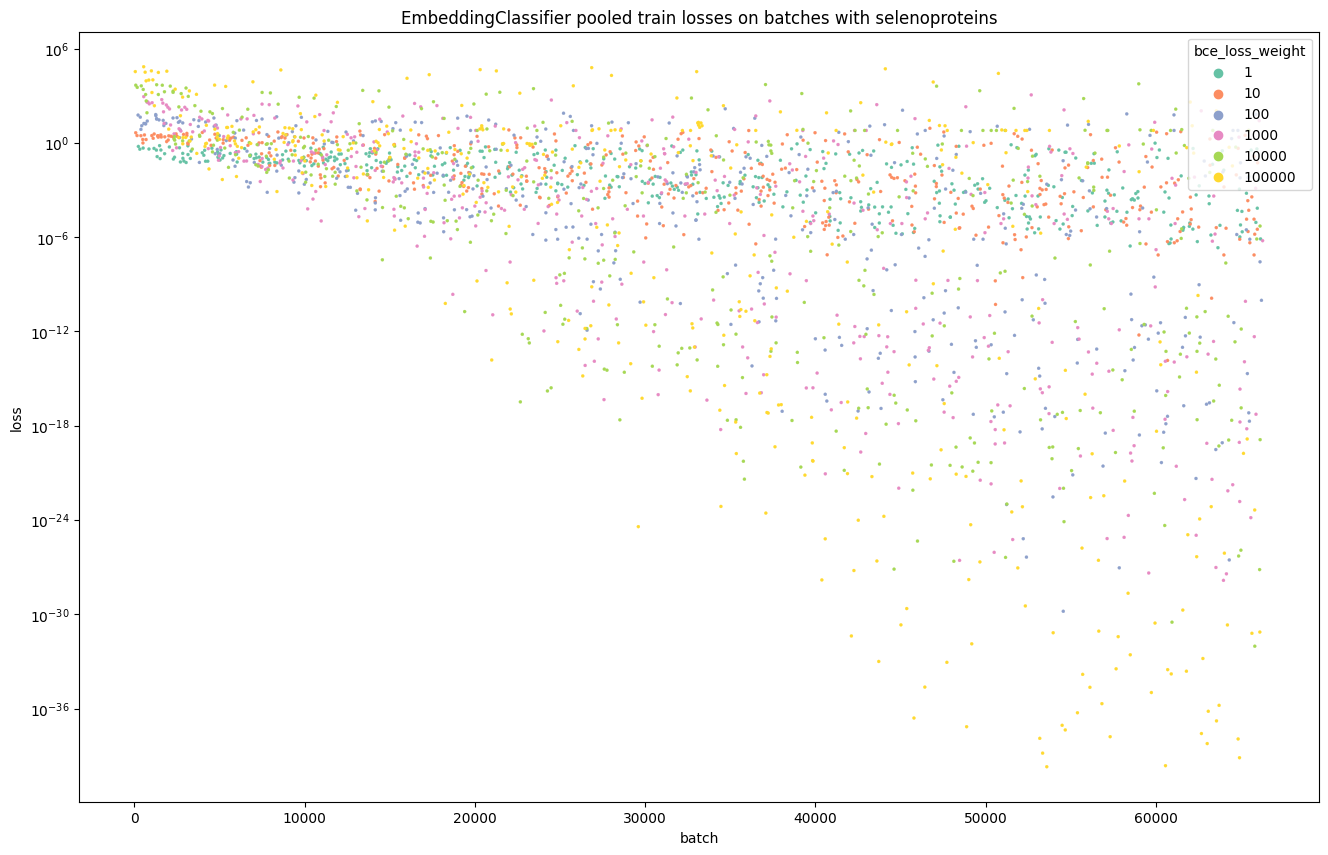

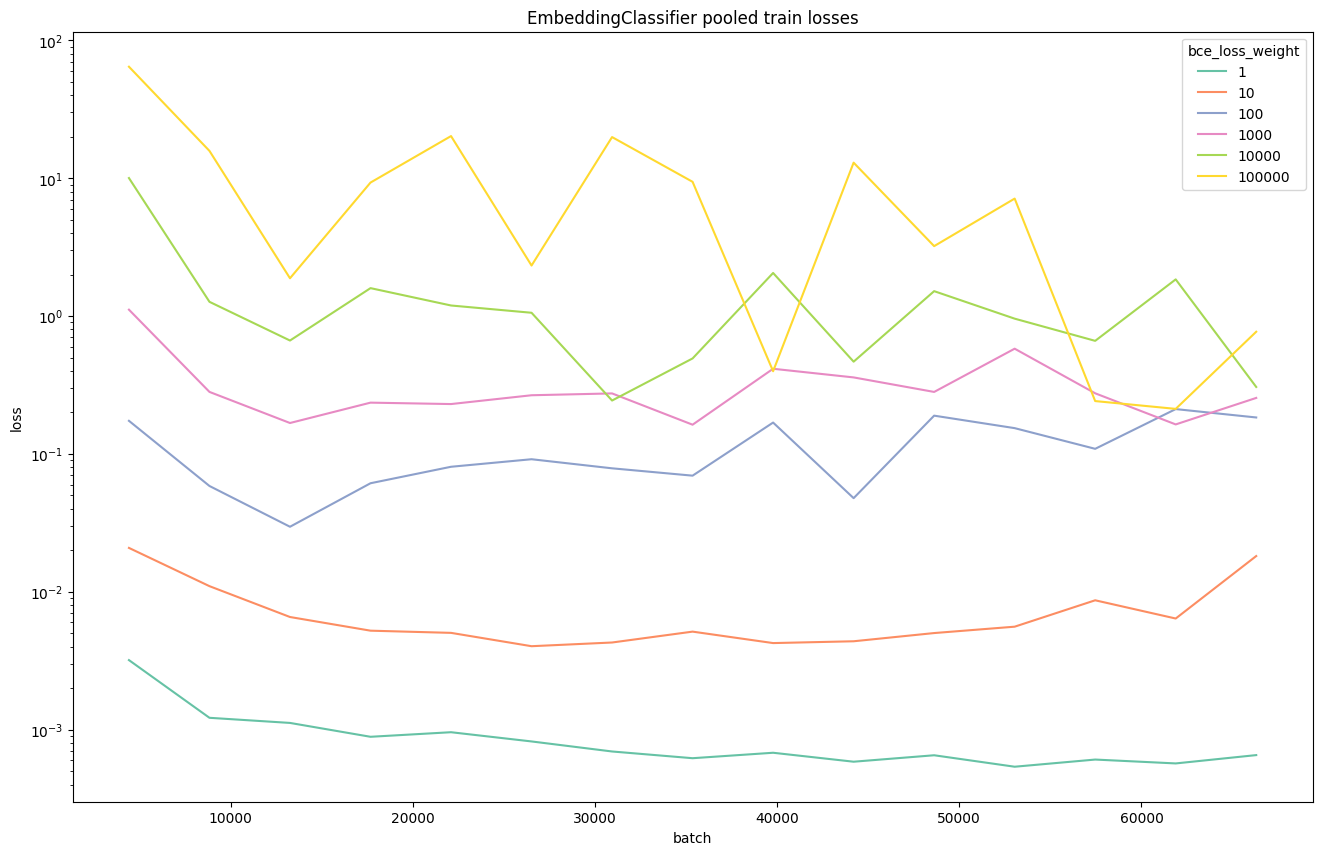

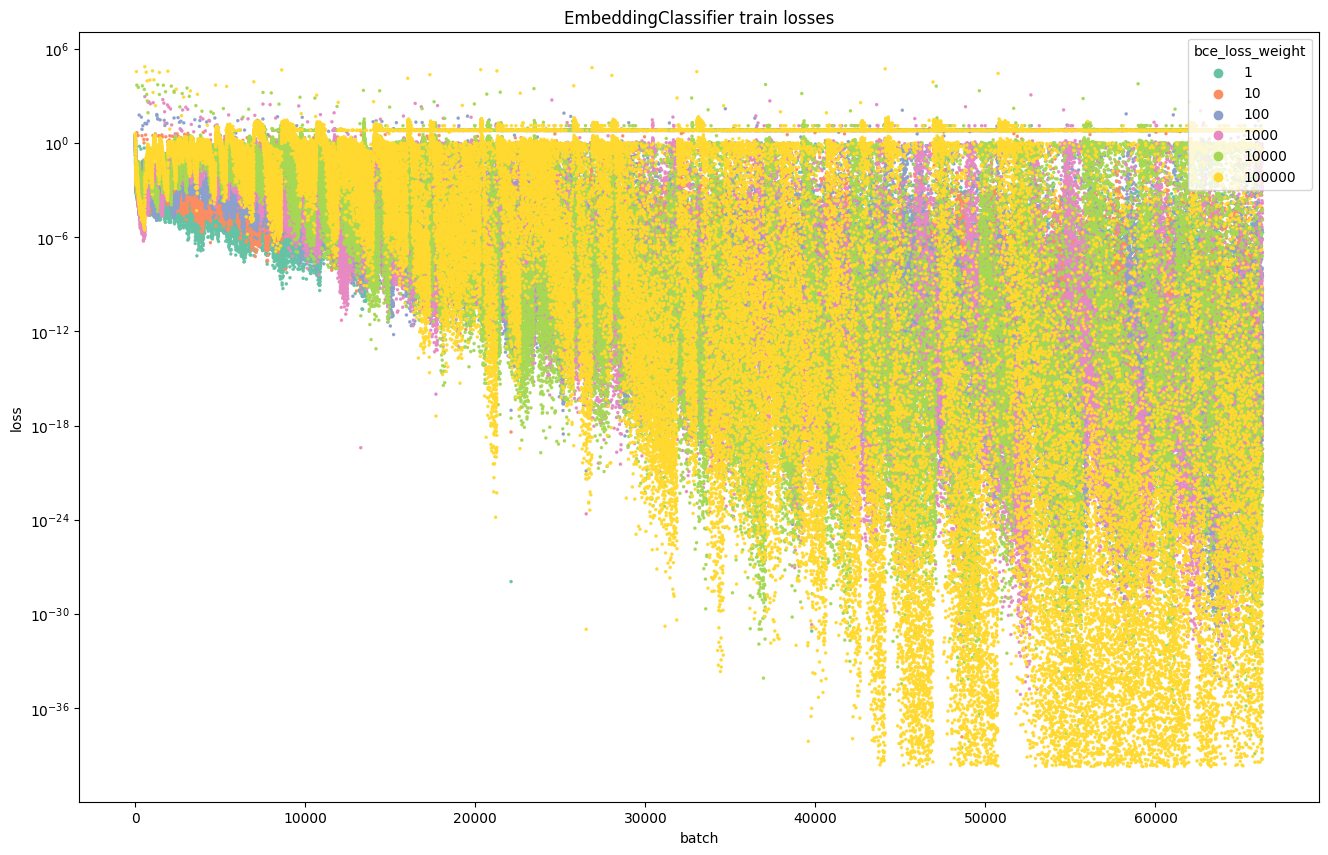

In [51]:
plot_train_losses(infos, path=FIGURE_DIR + 'emb_train_losses_pooled_batches_with_sec.png', title='EmbeddingClassifier pooled train losses on batches with selenoproteins', pool=False, sec_only=True)
plot_train_losses(infos, path=FIGURE_DIR + 'emb_train_losses_pooled.png', title='EmbeddingClassifier pooled train losses', pool=True, sec_only=False)
plot_train_losses(infos, path=FIGURE_DIR + 'emb_train_losses.png', title='EmbeddingClassifier train losses', pool=False, sec_only=False)
